In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import scipy.stats as stats
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import shap

## Common functions

In [2]:
# function to plot histograms
def plot_histogram(data, column_name):
    plt.hist(data[column_name], bins=10, edgecolor='black')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

In [3]:
# Function to evaluate the model and print metrics
def evaluate_model(model, X, y, set_name="Set"):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    
    print(f"{set_name} Performance:")
    print("  Accuracy:", accuracy)
    print("  Precision:", precision)
    print("  Recall:", recall)
    print("  F1 Score:", f1)
    print("  Classification Report:\n", classification_report(y, y_pred))

In [4]:
# Effects of various Hyperparameters

def hyperparameter_evaluation(model_name, model_parameters, X_train, y_train, X_val, y_val):
    
    if model_name == 'logistic_regression':
        model = LogisticRegression(multi_class='multinomial', solver=model_parameters['solver'], max_iter=model_parameters['max_iter'], C=model_parameters['C'])
        model.fit(X_train, y_train)
        # Evaluate on the training set
        y_pred_train = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        # Evaluate on the validation set
        y_pred_val = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_pred_val)
        
        return train_accuracy, val_accuracy 

    elif model_name == 'svm':
        model = SVC(C=model_parameters['C'], kernel=model_parameters['kernel'], degree=model_parameters['degree'], gamma=model_parameters['gamma'])
        model.fit(X_train, y_train)
        # Evaluate on the training set
        y_pred_train = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        # Evaluate on the validation set
        y_pred_val = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_pred_val)
        
        return train_accuracy, val_accuracy 
    
    elif model_name == 'random_forest':
        model = RandomForestClassifier(n_estimators=model_parameters['n_estimators'], max_depth=model_parameters['max_depth'], 
                            min_samples_split=model_parameters['min_samples_split'], 
                            min_samples_leaf=model_parameters['min_samples_leaf'], random_state=42)
        model.fit(X_train, y_train)
        # Evaluate on the training set
        y_pred_train = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        # Evaluate on the validation set
        y_pred_val = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_pred_val)
        
        return train_accuracy, val_accuracy 

In [5]:
def create_line_plots(x_label, title, train_accuracy_list, validation_accuracy_list, labels):
    plt.figure(figsize=(10, 6))
    plt.plot(labels, train_accuracy_list, marker='o', label='Train Accuracy')
    plt.plot(labels, validation_accuracy_list, marker='o', label='Validation Accuracy')
    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def create_bar_plots(x_label, title, train_accuracy_list, validation_accuracy_list, labels):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, train_accuracy_list, alpha=0.6, label='Training Accuracy')
    plt.bar(labels, validation_accuracy_list, alpha=0.6, label='Validation Accuracy')
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

## Question 1

1. There are no nulls in the data
2. Most of the features need to be scaled due to very high range of values
3. There are no categorical features in the dataset
4. No special treatment is required as data is well distributed and is either normally distributed or right or left skewed with no glaring outliers

In [8]:
data = pd.read_csv('train.csv')

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [11]:
data.shape

(2000, 21)

In [12]:
data.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [13]:
data['price_range'].value_counts()

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

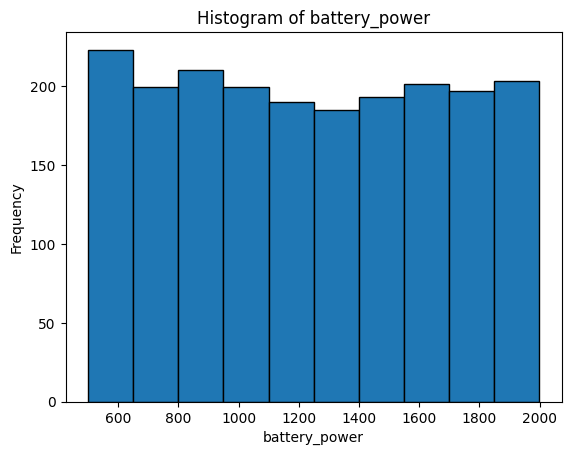

blue
0    1010
1     990
Name: count, dtype: int64


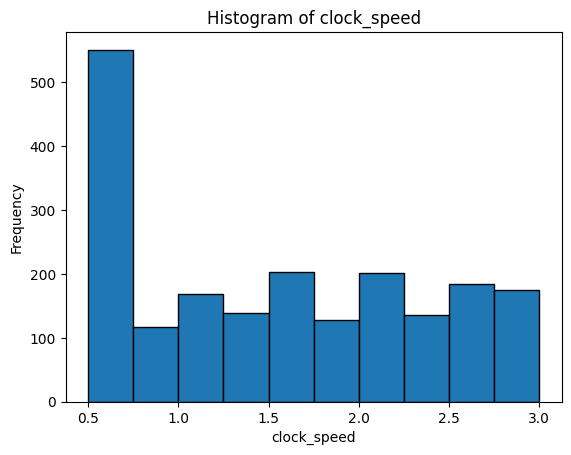

dual_sim
1    1019
0     981
Name: count, dtype: int64


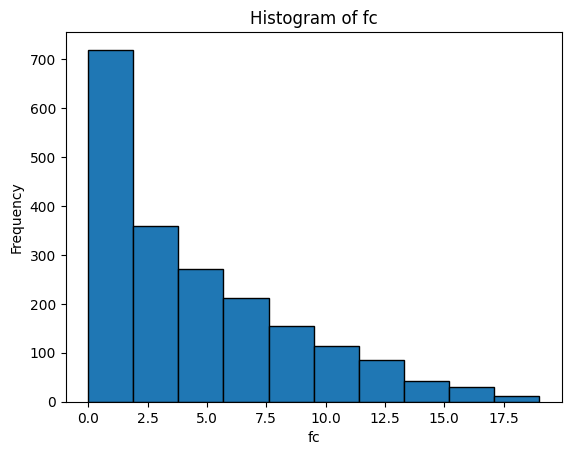

four_g
1    1043
0     957
Name: count, dtype: int64


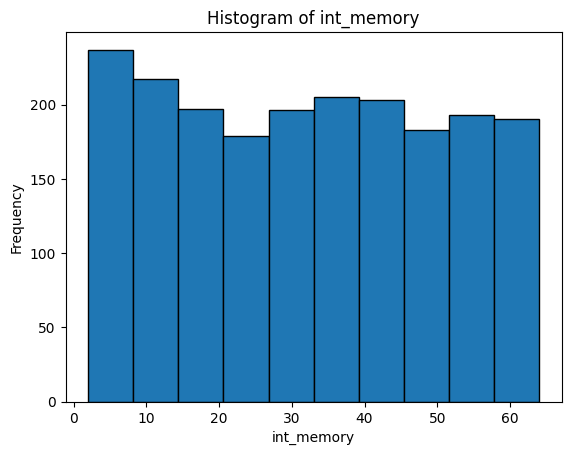

m_dep
0.1    320
0.2    213
0.8    208
0.5    205
0.7    200
0.3    199
0.9    195
0.6    186
0.4    168
1.0    106
Name: count, dtype: int64


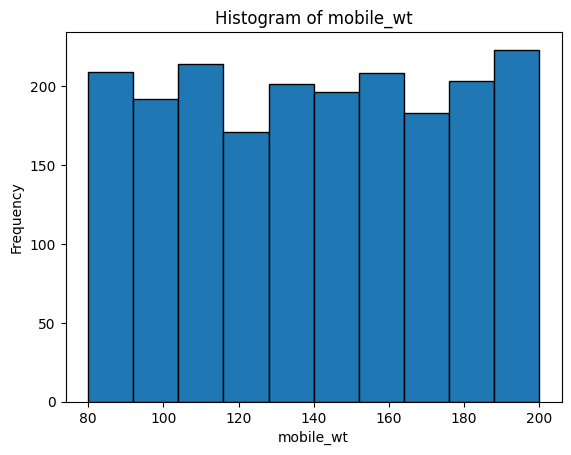

n_cores
4    274
7    259
8    256
2    247
3    246
5    246
1    242
6    230
Name: count, dtype: int64


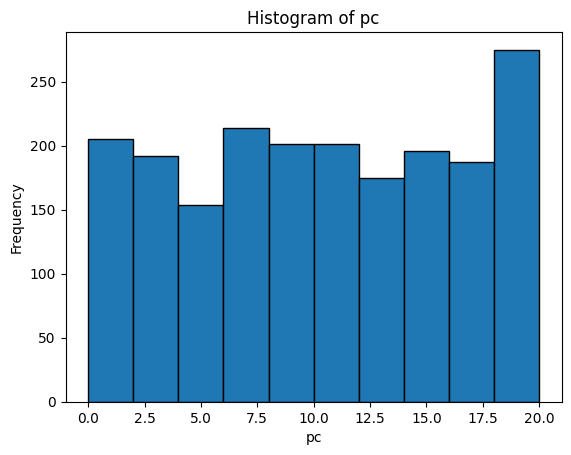

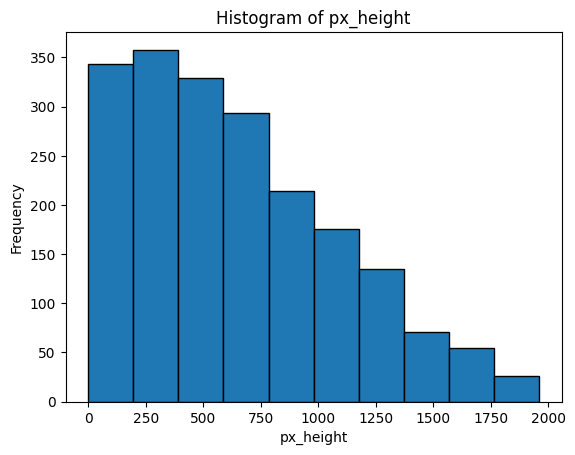

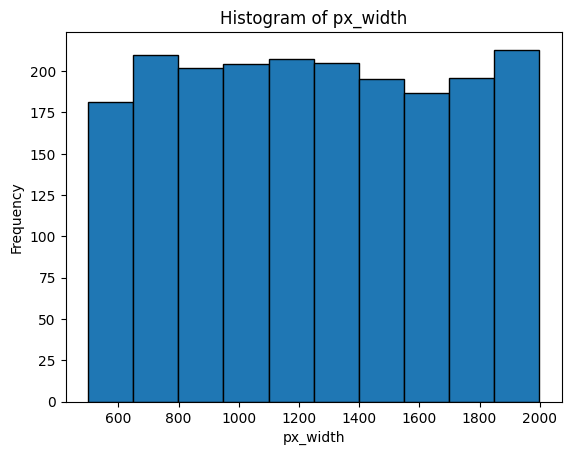

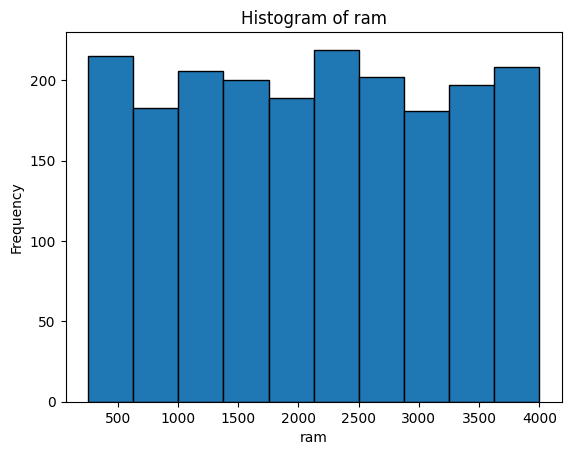

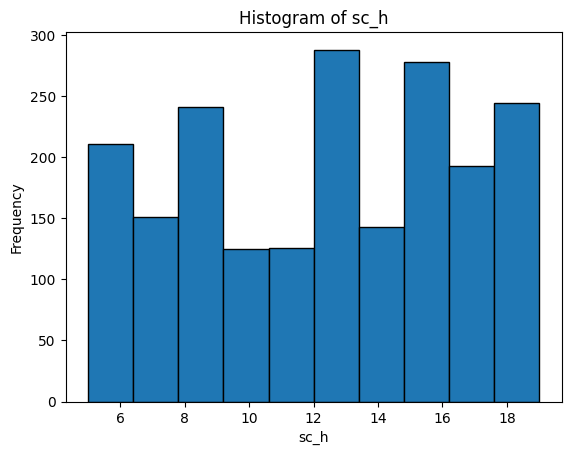

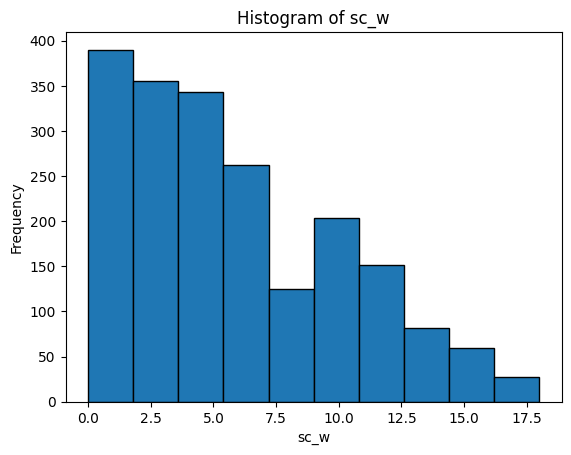

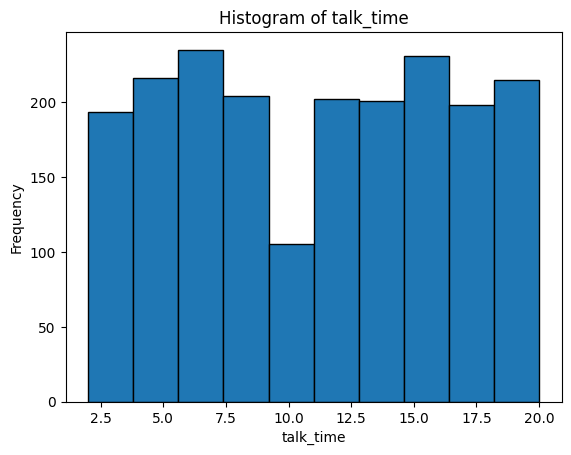

three_g
1    1523
0     477
Name: count, dtype: int64
touch_screen
1    1006
0     994
Name: count, dtype: int64
wifi
1    1014
0     986
Name: count, dtype: int64


In [14]:
for i in data.columns[:-1]:
    if data[i].nunique()>10:
        plot_histogram(data, i)
    else:
        print(data[i].value_counts())

## Question 2
1. RAM has highest correlation with the target variable
2. Most of the features show low correlation with the target variable

In [15]:
corr_data = data.corr()

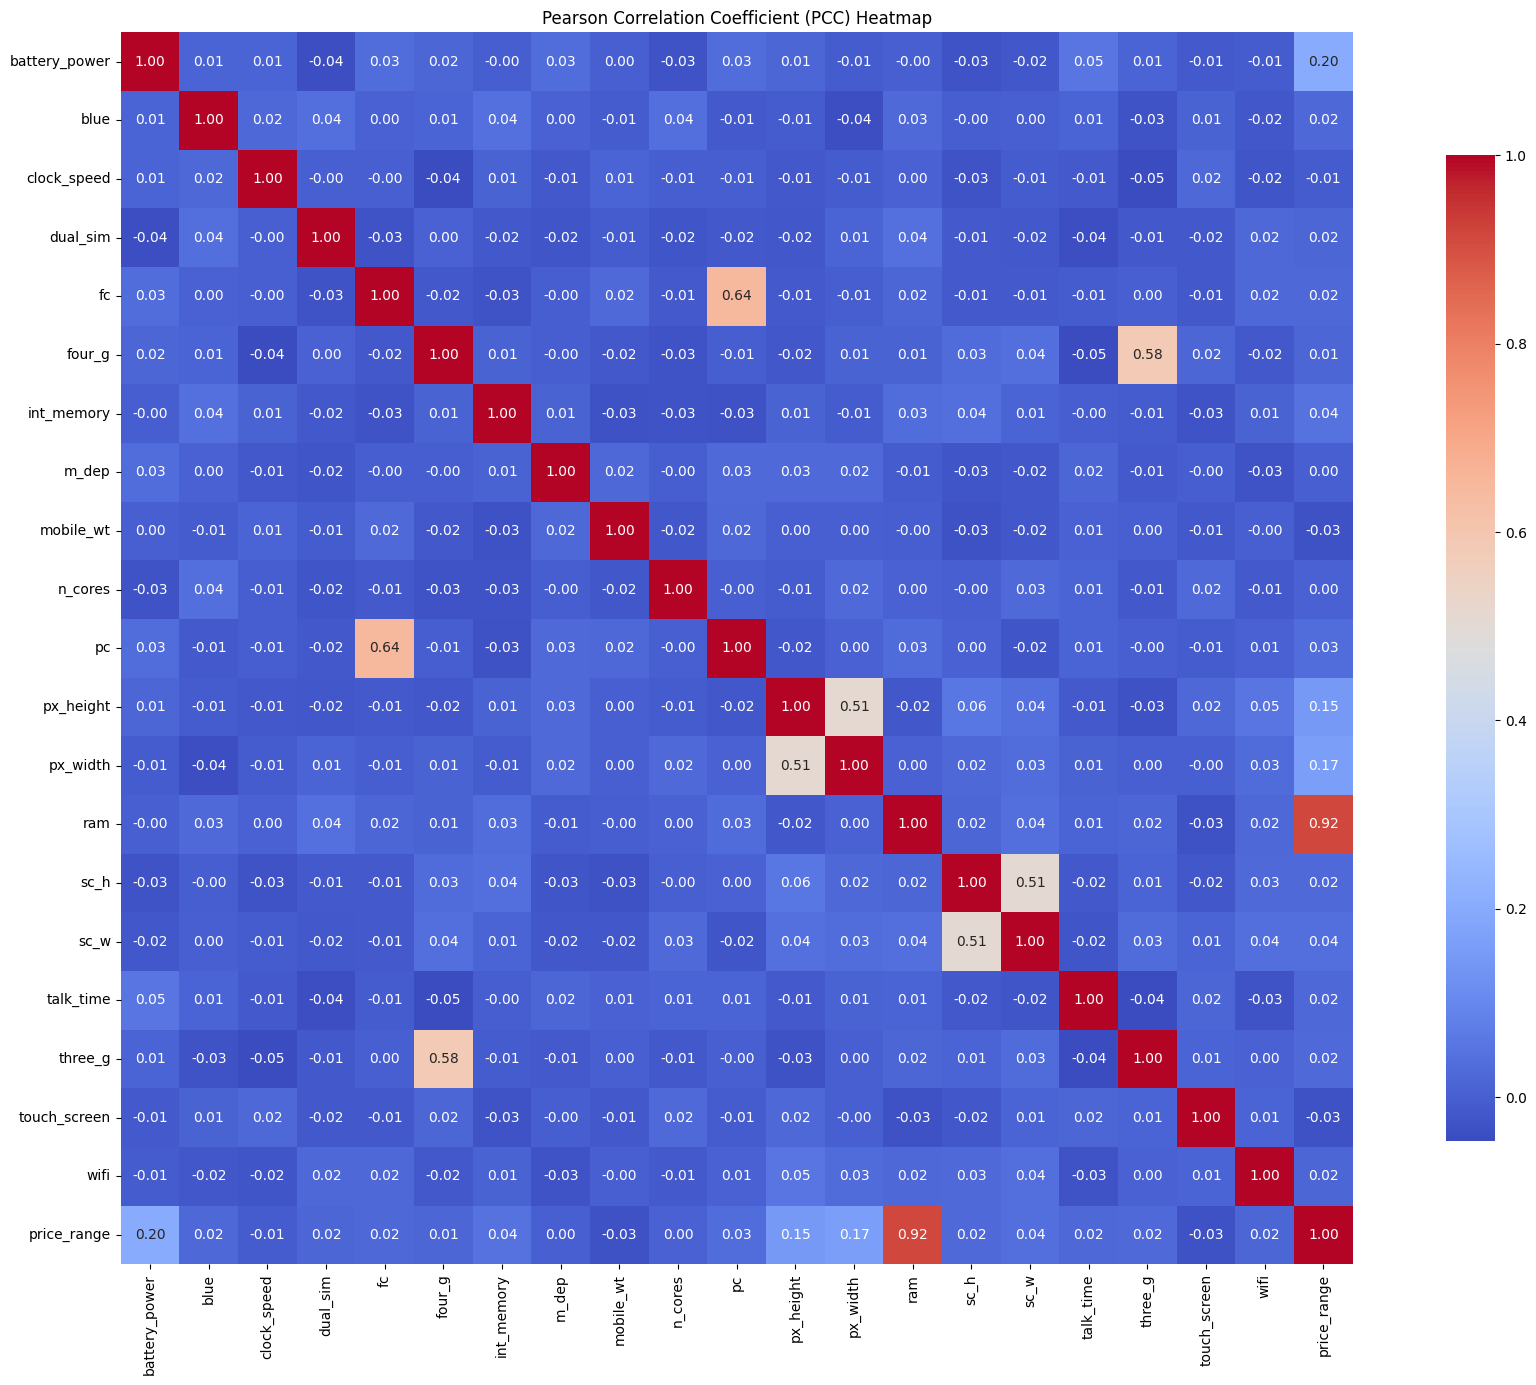

In [16]:
plt.figure(figsize=(24, 16))
sns.heatmap(corr_data, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Pearson Correlation Coefficient (PCC) Heatmap")
plt.xticks()
plt.yticks()
plt.show()

In [17]:
corr_data['price_range'].sort_values(ascending = False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

In [18]:
data.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

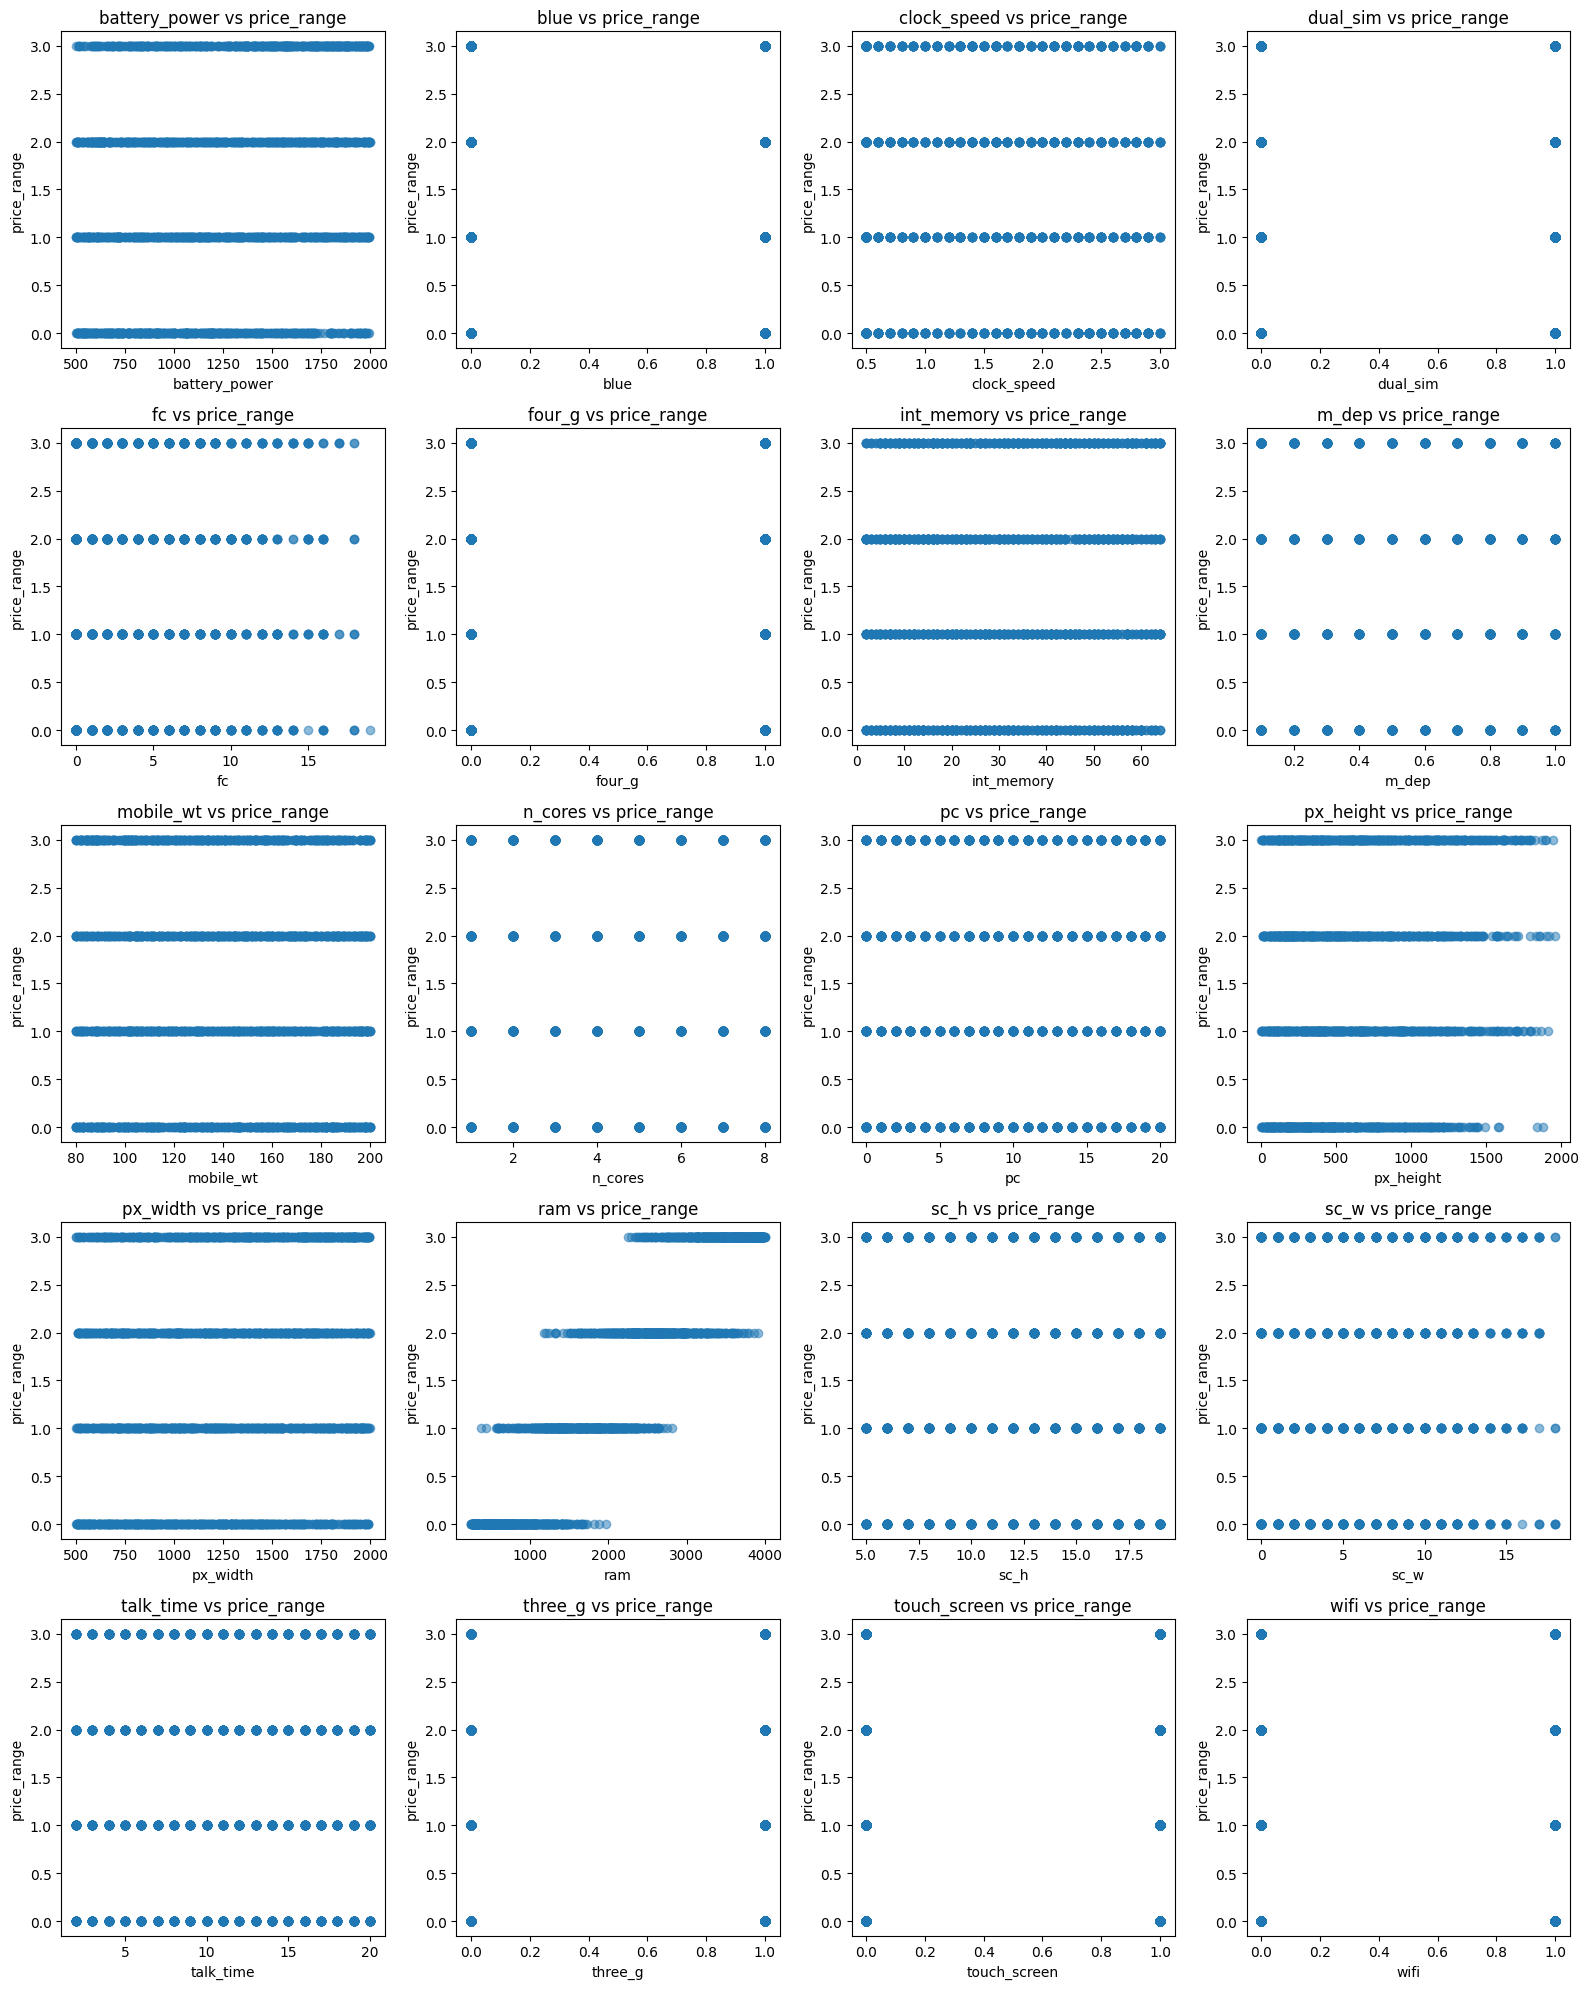

In [19]:
features = data.columns[:-1]

# Target variable
target = 'price_range'

# Create scatter plots for each feature against the target variable
plt.figure(figsize=(16, 20))  # Adjust the figure size as needed

for i, feature in enumerate(features):
    plt.subplot(5, 4, i+1)  # Create a 5x3 grid for subplots
    plt.scatter(data[feature], data[target], alpha=0.5)
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

## Question 3

* For tree based models we do not require to perform scaling as these models are invariant to monotonic transformations of the data.
* We are using the standard scaler to scale the x variables for svc and logistic regression models 

In [20]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['price_range'], axis=1),
                                                    data['price_range'],
                                                    stratify=data['price_range'],
                                                    test_size=0.2,
                                                    random_state=42)

In [21]:
# Further split X_train into X_train and X_validation
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train,
    y_train,
    stratify=y_train,
    test_size=0.25,
    random_state=42
)

In [22]:
scaler = StandardScaler()
np.random.seed(42)

## fit the data to calculate mean and variance of training data
scaler.fit(X_train)

## standardize the training set
X_train_scaled = scaler.fit_transform(X_train)

## standardize the test set using the mean of train set.
X_validation_scaled =scaler.transform(X_validation)

## standardize the test set using the mean of train set.
X_test_scaled =scaler.transform(X_test)

## Question4

We train the logistic regression model and try to see the performance by tweaking the following parameters:

* C - For C, we take different values(0.01, 0.1, 1, 10) and make a plot for accuracy vs C values. We also implement gridSearch and conclude that the model gives highest accuracy with C = 10. We can see from the plot below that as we increase the c value, for training dataset it follows a linear relationship till c = 0.1 but then reaches an elbow curve and is constant from that point. However, for the validation set, the accuracy increases as we increase the c value. The data seems to be simple as we dont need stronger regularization on the coefficients.
* Solver - We use different optimization algorithms in our experiment('newton-cg', 'saga', 'lbfgs') and plot the results on accuracy of the model.  
* Max number of iterations - Initially we took the following samples:100,200,300,500 and made the plot, but the accuracy seemed to be constant throughout.

In [25]:
# Define model and hyperparameters for tuning
lg_model = LogisticRegression(multi_class='multinomial')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],             # Regularization strength
    'solver': ['newton-cg', 'saga', 'lbfgs'], # Solver types that support multinomial
    'max_iter': [100, 200, 300, 500]          # Maximum number of iterations
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lg_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model from GridSearchCV
best_lg_model = grid_search.best_estimator_
print(grid_search.best_params_)

/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/N/soft/rhel8/python

{'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}


In [26]:
# Evaluate the model on training, validation, and test sets
evaluate_model(best_lg_model, X_train_scaled, y_train, set_name="Training")
evaluate_model(best_lg_model, X_validation_scaled, y_validation, set_name="Validation")
evaluate_model(best_lg_model, X_test_scaled, y_test, set_name="Test")

Training Performance:
  Accuracy: 0.9816666666666667
  Precision: 0.981651452513579
  Recall: 0.9816666666666667
  F1 Score: 0.9816413351320162
  Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       300
           1       0.98      0.97      0.98       300
           2       0.98      0.97      0.97       300
           3       0.98      0.99      0.99       300

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200

Validation Performance:
  Accuracy: 0.9825
  Precision: 0.9825949770538
  Recall: 0.9825
  F1 Score: 0.9824606693376361
  Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.99      0.96      0.97       100
           2       0.97      0.98      0.98       100
           3       0.99      0.9

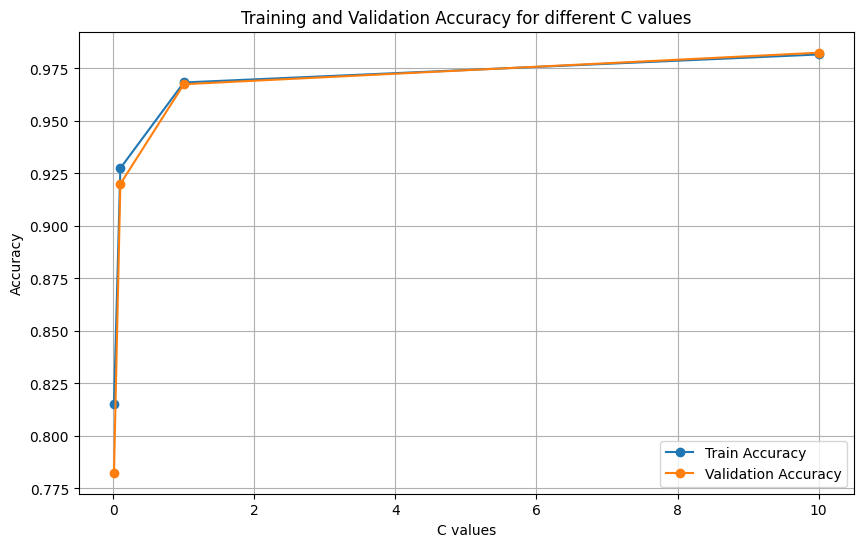

In [27]:
train_accuracy_list = []
validation_accuracy_list = []
c_values = [0.01, 0.1, 1, 10]
for C in c_values:
    model_parameters = {
        'solver' : 'newton-cg',
        'max_iter' : 100,
        'C' : C
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('logistic_regression', model_parameters, X_train_scaled, y_train, X_validation_scaled, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_line_plots('C values', 'Training and Validation Accuracy for different C values', train_accuracy_list, validation_accuracy_list, c_values)

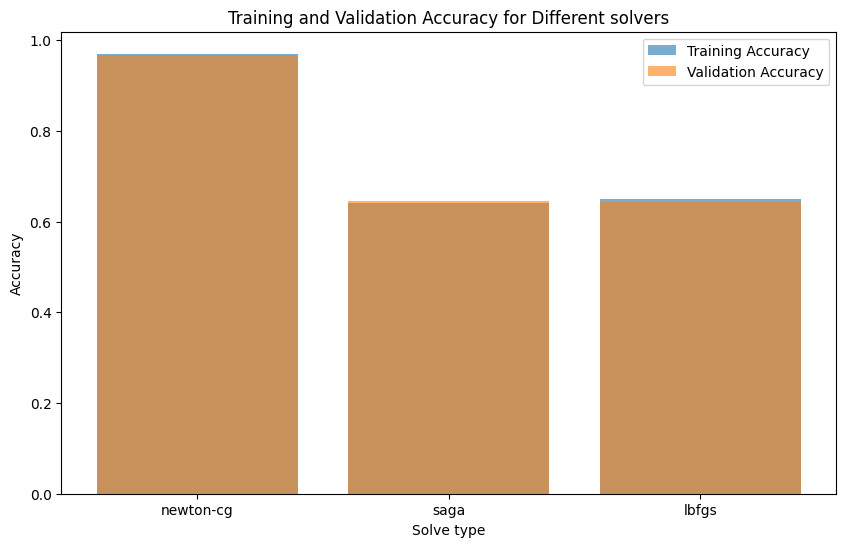

In [28]:
train_accuracy_list = []
validation_accuracy_list = []
solver_types = ['newton-cg', 'saga', 'lbfgs']
for solver in solver_types:
    model_parameters = {
        'solver' : solver,
        'max_iter' : 100,
        'C' : 10
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('logistic_regression', model_parameters, X_train, y_train, X_validation, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_bar_plots('Solve type', 'Training and Validation Accuracy for Different solvers', train_accuracy_list, validation_accuracy_list, solver_types)

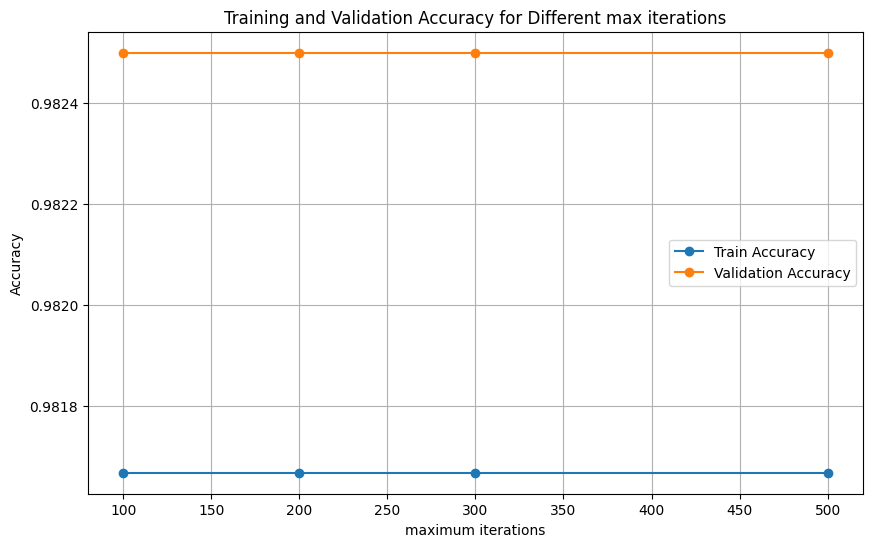

In [29]:
train_accuracy_list = []
validation_accuracy_list = []
max_iter_list = [100, 200, 300, 500] 
for max_iter in max_iter_list:
    model_parameters = {
        'solver' : 'newton-cg',
        'max_iter' : max_iter,
        'C' : 10
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('logistic_regression', model_parameters, X_train_scaled, y_train, X_validation_scaled, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_line_plots('maximum iterations', 'Training and Validation Accuracy for Different max iterations', train_accuracy_list, validation_accuracy_list, max_iter_list)

## SVC

* For SVC since the input data is large and the model is computationally very intensive I only used linear based kernels for SVC
* We see that the linear kernel has lower training accuracy than rbf kernel but validation accuracy was more for linear kernel
* Since the model is linearly separable the accuracy remains constant for different gamma values scale and auto
* C - For C, we take different values(0.1, 1, 10, 100) and make a plot for accuracy vs C values. We also implement gridSearch on training data and conclude that the model gives highest accuracy with C = 10. We can see from the plot below that as we increase the c value, for training dataset it follows a linear relationship and increases as we increase the c- value.

In [32]:
svc = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'kernel': ['linear', 'rbf'],      # Kernel type
    'degree': [2, 3, 4],              # Degree for polynomial kernel; ignored by other kernels
    'gamma': ['scale', 'auto']        # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}


# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Extract best parameters and apply them to a new SVC with probability=True
best_params = grid_search.best_params_
best_svc_model = SVC(**best_params, probability=True)  # Set probability=True here
best_svc_model.fit(X_train_scaled, y_train)  # Refit with probability=True

print(grid_search.best_params_)

{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [33]:
# Evaluate the model on training, validation, and test sets
evaluate_model(best_svc_model, X_train_scaled, y_train, set_name="Training")
evaluate_model(best_svc_model, X_validation_scaled, y_validation, set_name="Validation")
evaluate_model(best_svc_model, X_test_scaled, y_test, set_name="Test")

Training Performance:
  Accuracy: 0.9791666666666666
  Precision: 0.9791649712489842
  Recall: 0.9791666666666666
  F1 Score: 0.9791156257147275
  Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       300
           1       0.98      0.96      0.97       300
           2       0.98      0.97      0.97       300
           3       0.98      0.99      0.99       300

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200

Validation Performance:
  Accuracy: 0.98
  Precision: 0.9799959983993597
  Recall: 0.98
  F1 Score: 0.97994899489949
  Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.98      0.96      0.97       100
           2       0.97      0.97      0.97       100
           3       0.99      0.99 

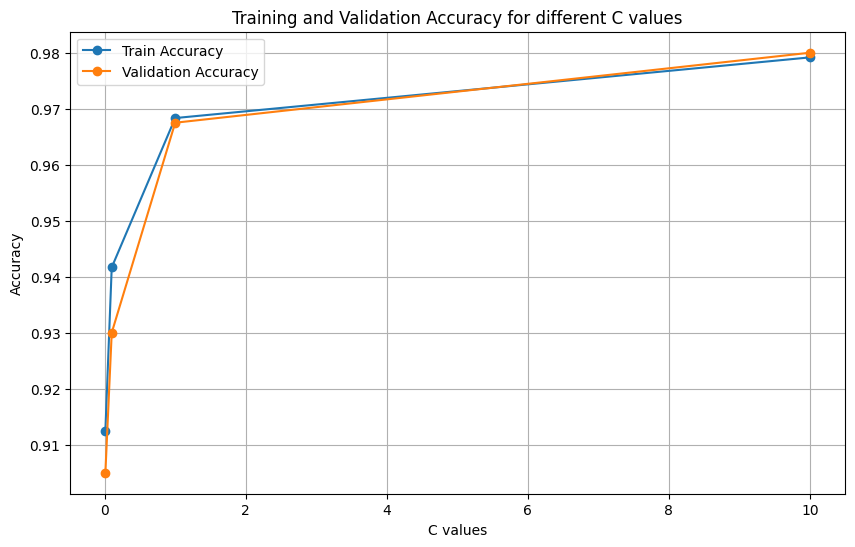

In [35]:
train_accuracy_list = []
validation_accuracy_list = []
c_values = [0.01, 0.1, 1, 10]
for C in c_values:
    model_parameters = {
        'C': C,
        'kernel': 'linear',
        'degree': 2,
        'gamma': 'scale'
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('svm', model_parameters, X_train_scaled, y_train, X_validation_scaled, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_line_plots('C values', 'Training and Validation Accuracy for different C values', train_accuracy_list, validation_accuracy_list, c_values)

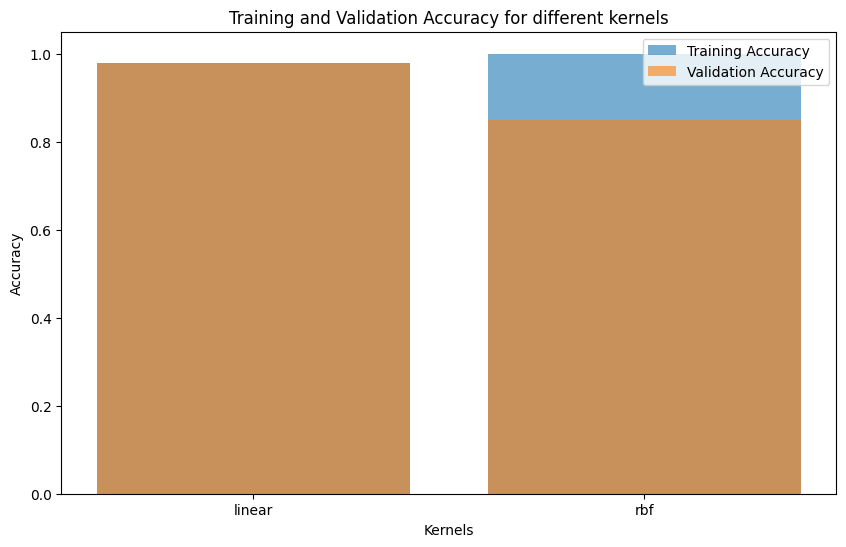

In [36]:
train_accuracy_list = []
validation_accuracy_list = []
kernel_types = ['linear', 'rbf']
for kernel in kernel_types:
    model_parameters = {
        'C': 10,
        'kernel': kernel,
        'degree': 2,
        'gamma': 'scale'
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('svm', model_parameters, X_train_scaled, y_train, X_validation_scaled, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_bar_plots('Kernels', 'Training and Validation Accuracy for different kernels', train_accuracy_list, validation_accuracy_list, kernel_types)

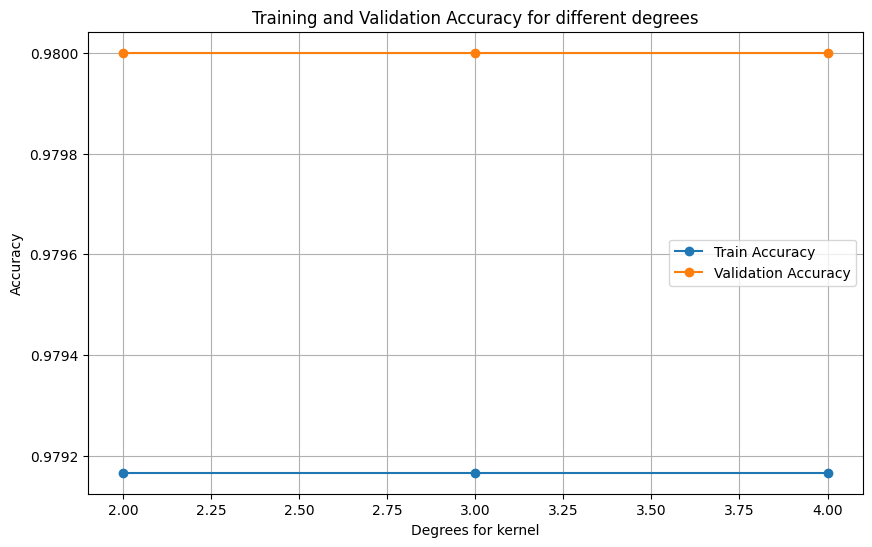

In [37]:
train_accuracy_list = []
validation_accuracy_list = []
degrees = [2, 3, 4]
for degree in degrees:
    model_parameters = {
        'C': 10,
        'kernel': 'linear',
        'degree': degree,
        'gamma': 'scale'
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('svm', model_parameters, X_train_scaled, y_train, X_validation_scaled, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_line_plots('Degrees for kernel', 'Training and Validation Accuracy for different degrees', train_accuracy_list, validation_accuracy_list, degrees)

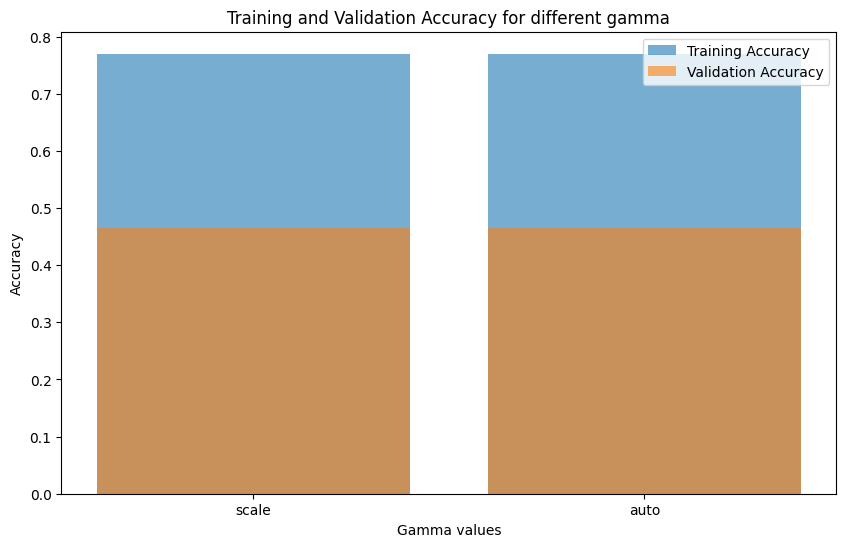

In [40]:
train_accuracy_list = []
validation_accuracy_list = []
gamma_values = ['scale', 'auto'] 
for gamma in gamma_values:
    model_parameters = {
        'C': 10,
        'kernel': 'poly',
        'degree': 2,
        'gamma': gamma
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('svm', model_parameters, X_train_scaled, y_train, X_validation_scaled, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)

gamma_values = ['scale', 'auto']
create_bar_plots('Gamma values', 'Training and Validation Accuracy for different gamma', train_accuracy_list, validation_accuracy_list, gamma_values)

## Random Forest

We train the Randomforest model and get the model accuracy of around 88.75% for the test set. We try to test the performance by tweaking the following hyper-parameters:

* n_estimators - As we increase the number of decision trees in random forest model, it increases the model accuracy for the validation set. For the training data the model accuracy remains stable with increase in n_estimators.
* max_depth - More the depth of tree, more complex patterns can be captured by the tree. We take sample set of (10,20,30). In our plot, we can observe that accuracy for validation data increases from depth = (10, 20). However it starts decreasing if we increase max_depth and each tree becomes overly complex and leads to overfitting.
* min_samples_split - We consider different minimum number of samples required to split an internal node. We see that a lower number allows more complex trees but may lead to overfitting and hence we increase the increase the number of samples.
* min_samples_leaf - We have taken the sample set of (2, 5, 10) and we observe that the model accuracy decreases as we increase min_samples_leaf. smaller number allows leafs to capture finer details in training data. Validation set suffers overfitting when the samples per list are less and has highest accurcay when the minimum samples are 5 as 10 minimum samples cause underfitting.

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees
    'max_depth': [10, 20, 30],              # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 5, 10]          # Minimum number of samples required at a leaf node
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [44]:
# Evaluate the model on training, validation, and test sets
evaluate_model(best_rf_model, X_train, y_train, set_name="Training")
evaluate_model(best_rf_model, X_validation, y_validation, set_name="Validation")
evaluate_model(best_rf_model, X_test, y_test, set_name="Test")

Training Performance:
  Accuracy: 0.9975
  Precision: 0.9975082504595892
  Recall: 0.9975
  F1 Score: 0.9974999861341439
  Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      0.99      0.99       300
           2       0.99      1.00      1.00       300
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Validation Performance:
  Accuracy: 0.85
  Precision: 0.8492428986488392
  Recall: 0.85
  F1 Score: 0.8488291000695276
  Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       100
           1       0.85      0.77      0.81       100
           2       0.79      0.79      0.79       100
           3       0.88      0.89      0.89       100

 

* RAM has the highest importance with positive correlation with the target variable
* Battery power, pixel width and height are also top features with positive correlation
* Mobile weight is also a top feature with negative correlation with y-variable

In [45]:
# Plotting shap plots to display best features as well as their influence on y-variable
X_importance = X_validation
explainer = shap.Explainer(best_rf_model.predict, X_importance)
shap_values = explainer(X_importance)

PermutationExplainer explainer: 401it [03:30,  1.89it/s]                         


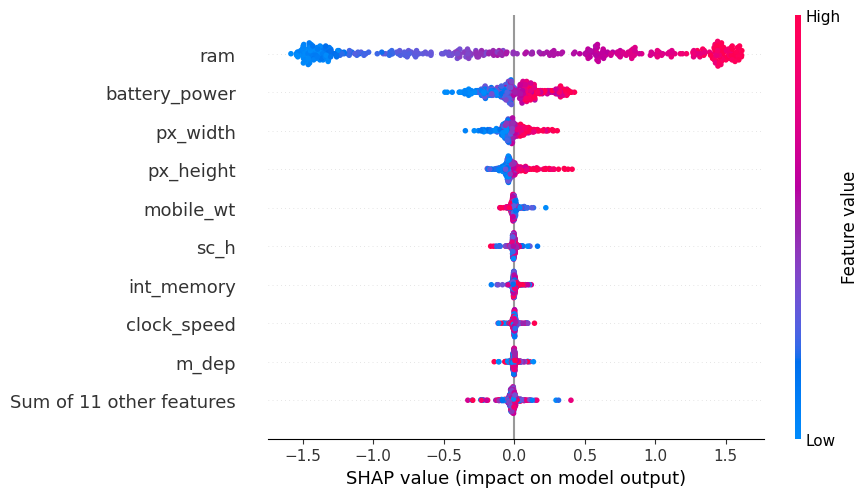

In [46]:
shap.plots.beeswarm(shap_values)

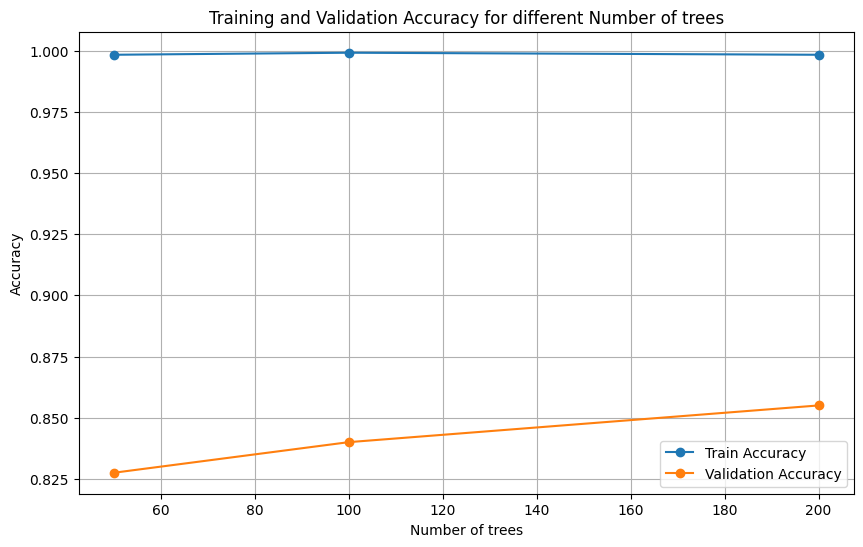

In [47]:
train_accuracy_list = []
validation_accuracy_list = []
n_estimators_list = [50, 100, 200]
for n_estimators in n_estimators_list:
    model_parameters = {
        'n_estimators': n_estimators,
        'max_depth': 10,              
        'min_samples_split': 5,        
        'min_samples_leaf': 2          
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('random_forest', model_parameters, X_train, y_train, X_validation, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_line_plots('Number of trees', 'Training and Validation Accuracy for different Number of trees', train_accuracy_list, validation_accuracy_list, n_estimators_list)

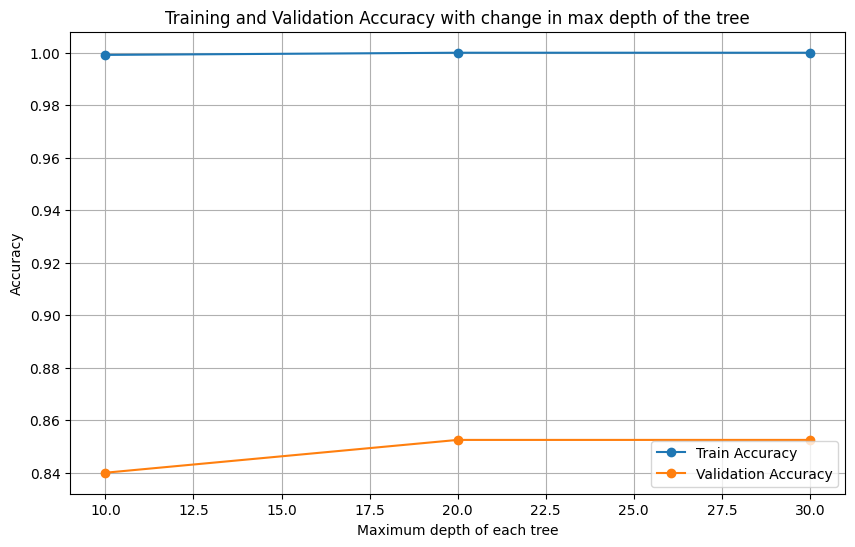

In [48]:
train_accuracy_list = []
validation_accuracy_list = []
max_depth_list = [10, 20, 30]
for max_depth in max_depth_list:
    model_parameters = {
        'n_estimators': 100,
        'max_depth': max_depth,              
        'min_samples_split': 5,        
        'min_samples_leaf': 2          
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('random_forest', model_parameters, X_train, y_train, X_validation, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_line_plots('Maximum depth of each tree', 'Training and Validation Accuracy with change in max depth of the tree', train_accuracy_list, validation_accuracy_list, max_depth_list)

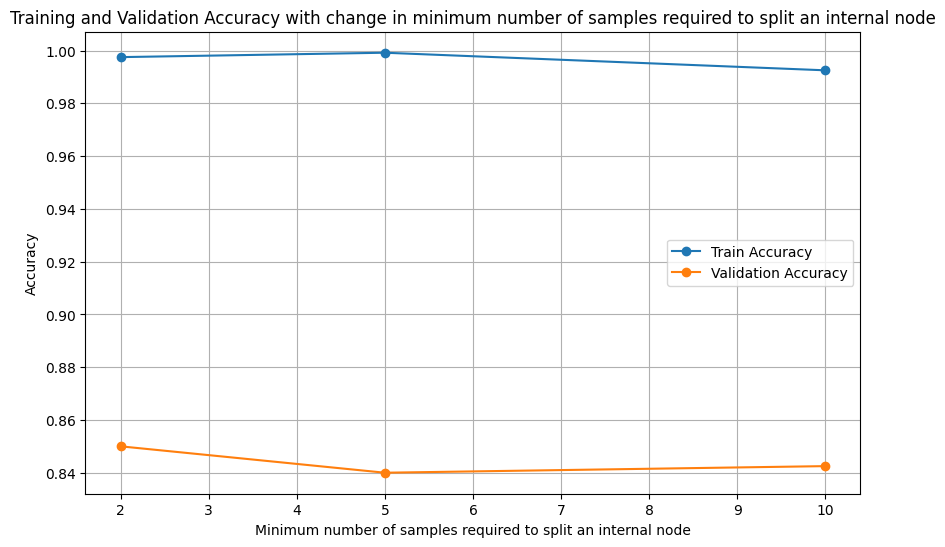

In [49]:
train_accuracy_list = []
validation_accuracy_list = []
min_samples_split_list = [2, 5, 10]
for min_samples_split in min_samples_split_list:
    model_parameters = {
        'n_estimators': 100,
        'max_depth': 10,              
        'min_samples_split': min_samples_split,        
        'min_samples_leaf': 2          
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('random_forest', model_parameters, X_train, y_train, X_validation, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_line_plots('Minimum number of samples required to split an internal node', 'Training and Validation Accuracy with change in minimum number of samples required to split an internal node', train_accuracy_list, validation_accuracy_list, min_samples_split_list)

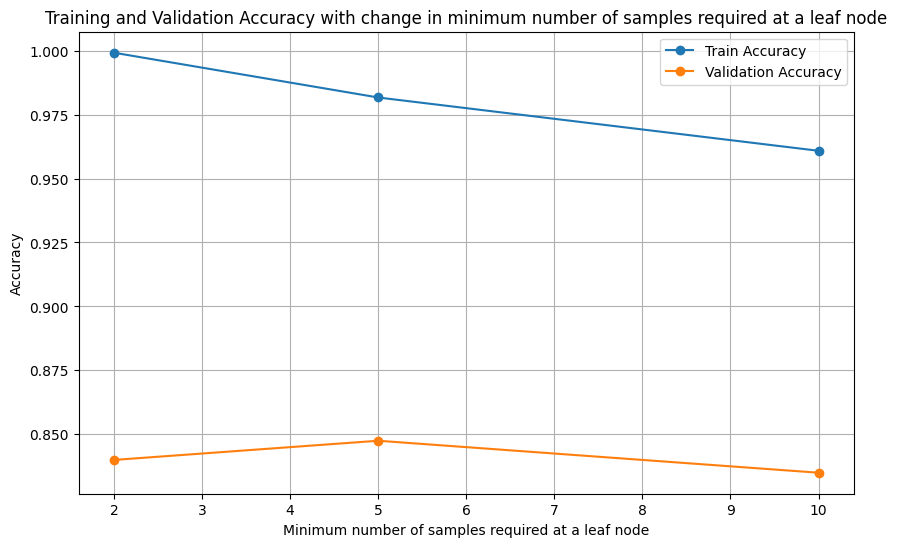

In [50]:
train_accuracy_list = []
validation_accuracy_list = []
min_samples_leaf_list = [2, 5, 10]
for min_samples_leaf in min_samples_leaf_list:
    model_parameters = {
        'n_estimators': 100,
        'max_depth': 10,              
        'min_samples_split': 5,        
        'min_samples_leaf': min_samples_leaf         
    }
    train_accuracy, val_accuracy = hyperparameter_evaluation('random_forest', model_parameters, X_train, y_train, X_validation, y_validation)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    
create_line_plots('Minimum number of samples required at a leaf node', 'Training and Validation Accuracy with change in minimum number of samples required at a leaf node', train_accuracy_list, validation_accuracy_list, min_samples_leaf_list)

## Ensemble model

For Logistic regression, we got the accuracy(%) of:
* Training - 98
* Validation - 98
* Test - 7
 
For SVC, we got:
* Training - 98
* Validation - 98
* Test - 97
 
For Random Forest, we got:
* Training - 99
* Validation - 85
* Test - 88
 
We used an Ensemble model to get the get the best accuracy. We use hard voting to get high accuracy and soft voting to get prediction probabilities
 
We get an accuracy of:
* Validation - 80
* Test - 72.22
 
Hence, for the test set we get the best accuracy using ensemble model

In [51]:
from sklearn.ensemble import VotingClassifier

In [52]:
ensemble_model1 = VotingClassifier(
    estimators=[('rf', best_rf_model), ('svc', best_svc_model), ('logreg', best_lg_model)],
    voting='soft'  
)
ensemble_model1.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=10, degree=2, kernel='linear',
                                  probability=True)),
                             ('logreg',
                              LogisticRegression(C=10,
                                                 multi_class='multinomial',
                                                 solver='newton-cg'))],
                 voting='soft')

In [53]:
# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[('rf', best_rf_model), ('svc', best_svc_model), ('logreg', best_lg_model)],
    voting='hard'  # Soft voting for probability-based combination
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=10, degree=2, kernel='linear',
                                  probability=True)),
                             ('logreg',
                              LogisticRegression(C=10,
                                                 multi_class='multinomial',
                                                 solver='newton-cg'))])

In [54]:
# Predict on the validation set
y_pred = ensemble_model.predict(X_validation)

# Evaluate ensemble performance
accuracy = accuracy_score(y_validation, y_pred)
report = classification_report(y_validation, y_pred)

print(f"Ensemble Model Accuracy: {accuracy}")
print("Ensemble Model Classification Report:\n", report)

Ensemble Model Accuracy: 0.9775
Ensemble Model Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       100
           1       0.98      0.95      0.96       100
           2       0.96      0.98      0.97       100
           3       0.99      0.99      0.99       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

